#                                 Detection of Network Intrusion

In [5]:
!pip install lightgbm

In [6]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


## Importation des librairies necessaires

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import warnings
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
import itertools
from xgboost import XGBClassifier
from tabulate import tabulate
import pickle

## Importation de dataset 

In [8]:
Data=pd.read_csv('networkintrusion.csv')
Data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,private,REJ,0.0,0.0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly
1,0,tcp,private,REJ,0.0,0.0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly
2,2,tcp,ftp_data,SF,12983.0,0.0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal
3,0,icmp,eco_i,SF,20.0,0.0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,anomaly
4,1,tcp,telnet,RSTO,0.0,15.0,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,anomaly


## 1 - Prétaitement et exploration des données

In [9]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22544 non-null  int64  
 1   protocol_type                22544 non-null  object 
 2   service                      22544 non-null  object 
 3   flag                         22544 non-null  object 
 4   src_bytes                    22538 non-null  float64
 5   dst_bytes                    22538 non-null  float64
 6   land                         22544 non-null  int64  
 7   wrong_fragment               22544 non-null  int64  
 8   urgent                       22544 non-null  int64  
 9   hot                          22544 non-null  int64  
 10  num_failed_logins            22544 non-null  int64  
 11  logged_in                    22544 non-null  int64  
 12  num_compromised              22544 non-null  int64  
 13  root_shell      

In [10]:
Data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,22544.000000,2.253800e+04,2.253800e+04,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,...,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000,22544.000000
mean,218.859076,1.039812e+04,2.055584e+03,0.000311,0.008428,0.000710,0.105394,0.021647,0.442202,0.119899,...,193.869411,140.750532,0.608722,0.090540,0.132261,0.019638,0.097814,0.099426,0.233385,0.226683
std,1407.176612,4.728493e+05,2.122190e+04,0.017619,0.142599,0.036473,0.928428,0.150328,0.496659,7.269597,...,94.035663,111.783972,0.435688,0.220717,0.306268,0.085394,0.273139,0.281866,0.387229,0.400875
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,121.000000,15.000000,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.400000e+01,4.600000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,168.000000,0.920000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.870000e+02,6.010000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.060000,0.030000,0.010000,0.000000,0.000000,0.360000,0.170000
max,57715.000000,6.282565e+07,1.345927e+06,1.000000,3.000000,3.000000,101.000000,4.000000,1.000000,796.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
Data.describe(include='object')

,protocol_type,service,flag,class
count,22544,22544,22544,22544
unique,3,64,11,2
top,tcp,http,SF,anomaly
freq,18880,7853,14875,12833


In [12]:
Data.shape

(22544, 40)

In [13]:
#Tester si on a des valeur nulles
Data.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      6
dst_bytes                      6
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
num_root                       0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          9
srv_count                      9
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_host_rate             0
dst_host_count                 0
dst_host_s

In [14]:
total = Data.shape[0]
missing_columns = [col for col in Data.columns if Data[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = Data[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")

src_bytes: 6 (0.027%)
dst_bytes: 6 (0.027%)
count: 9 (0.04%)
srv_count: 9 (0.04%)


In [15]:
print(f"Number of duplicate rows: {Data.duplicated().sum()}")

Number of duplicate rows: 3


<Axes: xlabel='class', ylabel='count'>

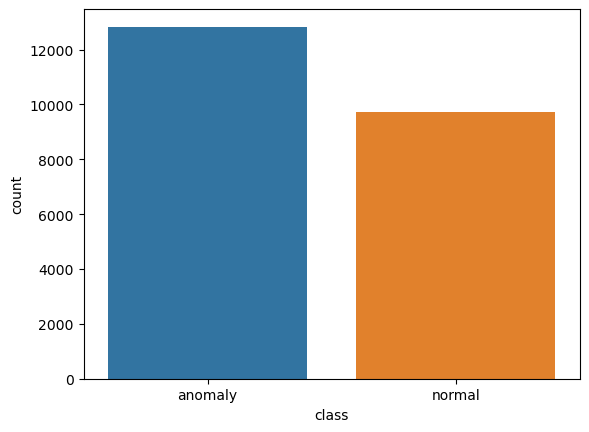

In [16]:
sns.countplot(x=Data['class'])

In [17]:
print('Class distribution Training set:')
print(Data['class'].value_counts())

Class distribution Training set:
class
anomaly    12833
normal      9711
Name: count, dtype: int64


In [18]:
Data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,private,REJ,0.0,0.0,0,0,0,0,...,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly
1,0,tcp,private,REJ,0.0,0.0,0,0,0,0,...,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,anomaly
2,2,tcp,ftp_data,SF,12983.0,0.0,0,0,0,0,...,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal
3,0,icmp,eco_i,SF,20.0,0.0,0,0,0,0,...,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,anomaly
4,1,tcp,telnet,RSTO,0.0,15.0,0,0,0,0,...,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,anomaly


In [19]:
def le(Data):
    for col in Data.columns:
        if Data[col].dtype == 'object':
                label_encoder = LabelEncoder()
                Data[col] = label_encoder.fit_transform(Data[col])

le(Data)
Data['num_outbound_cmds']

0        0
1        0
2        0
3        0
4        0
        ..
22539    0
22540    0
22541    0
22542    0
22543    0
Name: num_outbound_cmds, Length: 22544, dtype: int64

In [20]:
Data.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'num_root', 'num_shells', 'num_access_files', 'num_outbound_cmds',
       'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')

In [21]:
Data.drop(['num_outbound_cmds'], axis=1, inplace=True)

In [22]:
X = Data.drop(['class'], axis=1)
Y = Data['class']

In [23]:
rfc = RandomForestClassifier()

X_cleaned = X.dropna()
Y_cleaned = Y[X.index.isin(X_cleaned.index)]

X = X_cleaned
Y = Y_cleaned

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_cleaned, Y_cleaned)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['duration',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_rerror_rate']

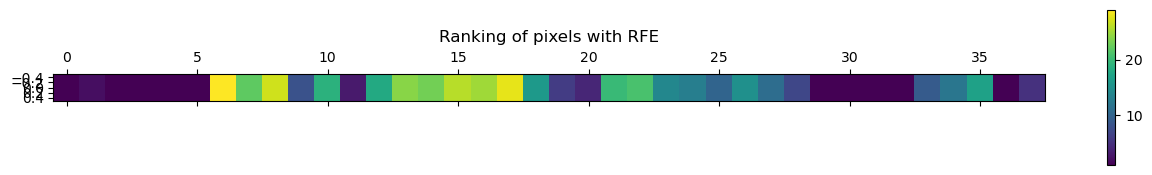

In [24]:
digits=40
#ranking = rfe.ranking_.reshape((1,digits))
ranking = rfe.ranking_.reshape((1, -1))
# Plot pixel ranking
import pylab as pl
pl.matshow(ranking)
pl.colorbar()
pl.title("Ranking of pixels with RFE")
pl.show()

In [25]:
X.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'num_root', 'num_shells', 'num_access_files', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')

In [26]:
print(selected_features)

['duration', 'service', 'flag', 'src_bytes', 'dst_bytes', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_rerror_rate']


In [27]:
X = X[selected_features]

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.70, random_state=2)

In [29]:
scale = StandardScaler()
x_train = scale.fit_transform(x_train)
x_test = scale.transform(x_test)

In [30]:
x_train.shape

(15770, 10)

In [31]:
x_test.shape

(6759, 10)

In [32]:
y_train.shape

(15770,)

In [33]:
y_test.shape

(6759,)

In [34]:
y_test

565      0
1032     1
7154     0
15226    0
11712    1
        ..
15252    1
3145     1
3373     1
2635     1
17753    0
Name: class, Length: 6759, dtype: int32

## 2- Visualisation des données

In [35]:

numerical_features= ['duration', 'src_bytes', 'dst_bytes', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_rerror_rate']
categorical_features =['service', 'flag']
Data = Data[numerical_features + categorical_features + ['class']]

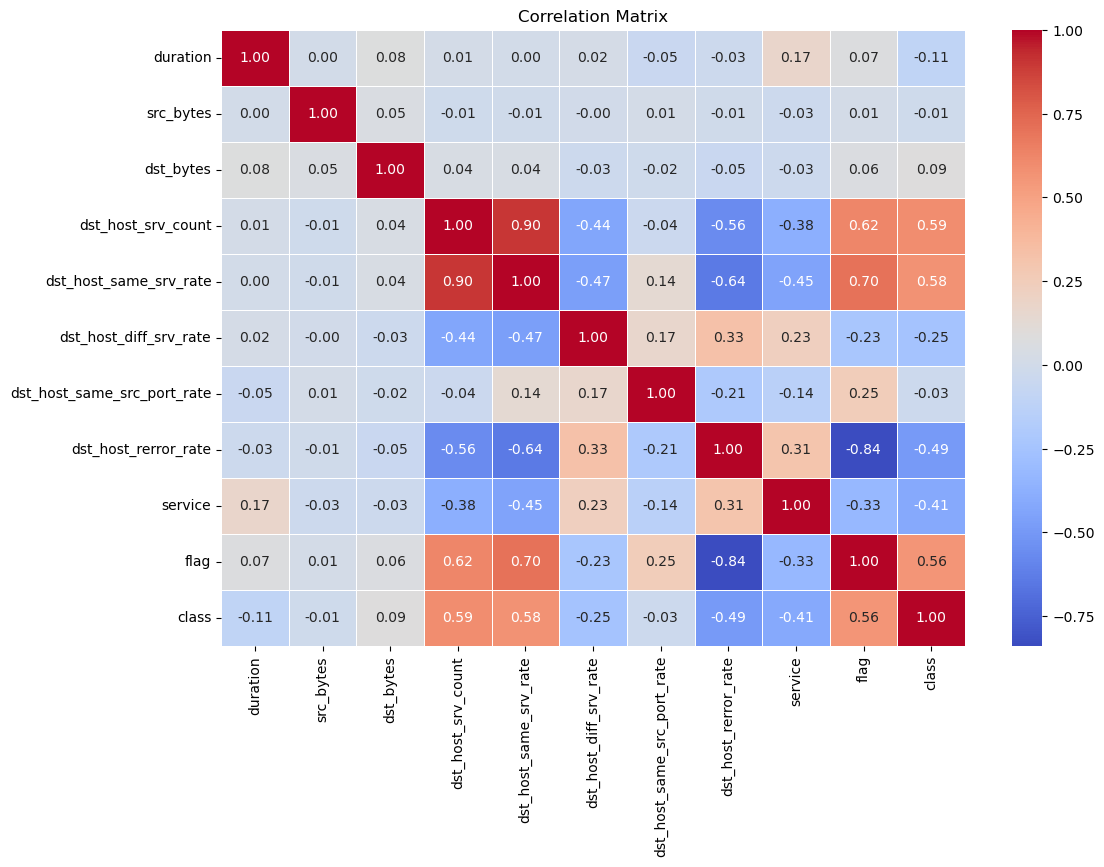

In [36]:
# Correlation matrix
correlation_matrix = Data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

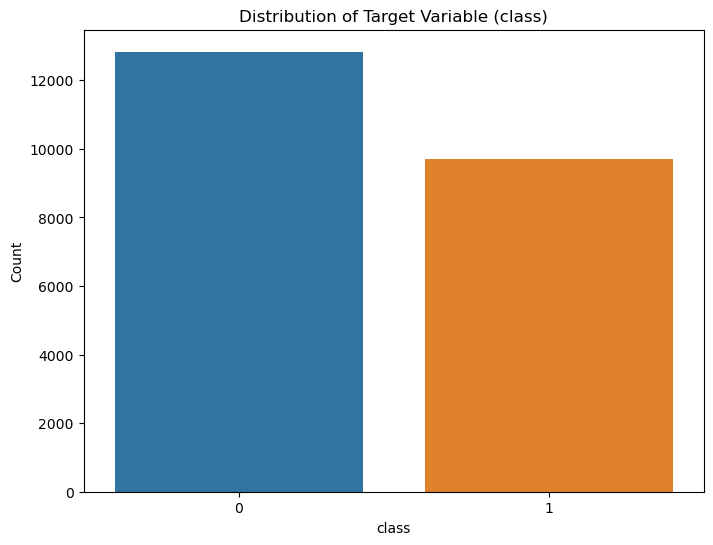

In [37]:
# Distribution of target variable
plt.figure(figsize=(8, 6))
sns.countplot(x="class", data=Data)
plt.title("Distribution of Target Variable (class)")
plt.ylabel("Count")
plt.show()

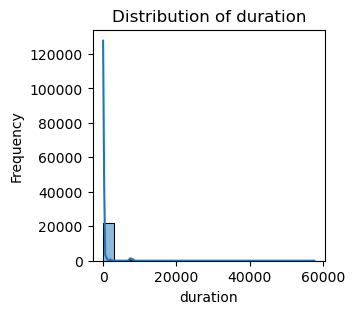

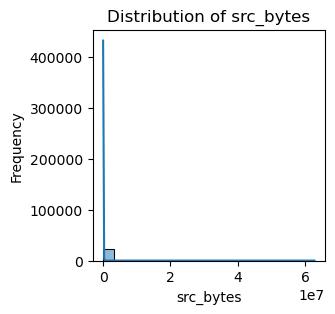

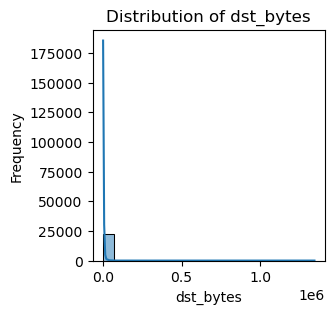

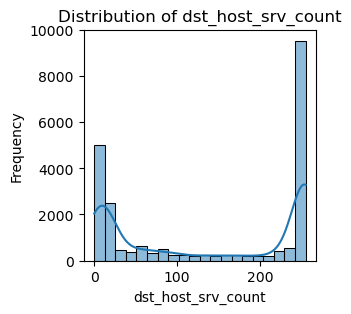

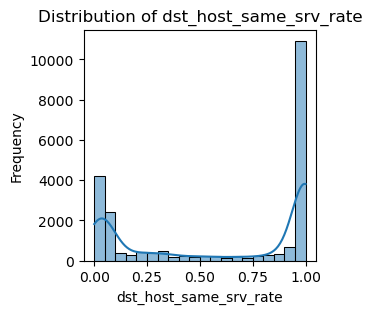

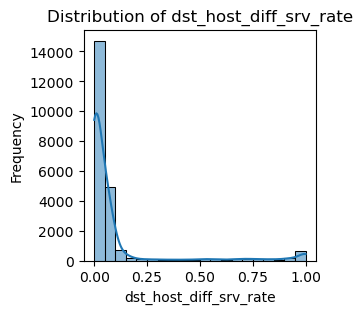

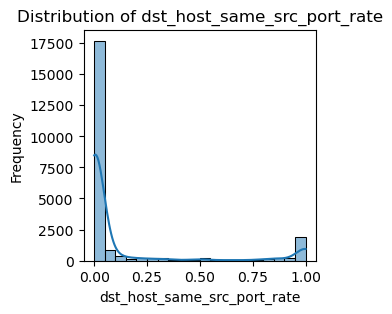

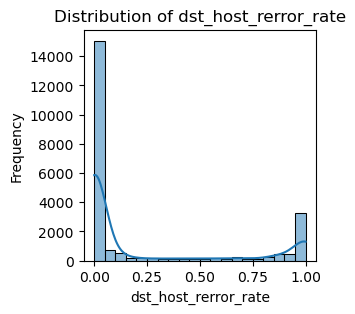

In [77]:
# Distribution of numerical features
for feature in numerical_features:
    plt.figure(figsize=(3, 3))
    sns.histplot(Data[feature], kde=True, bins=20)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

C:\Users\hp\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


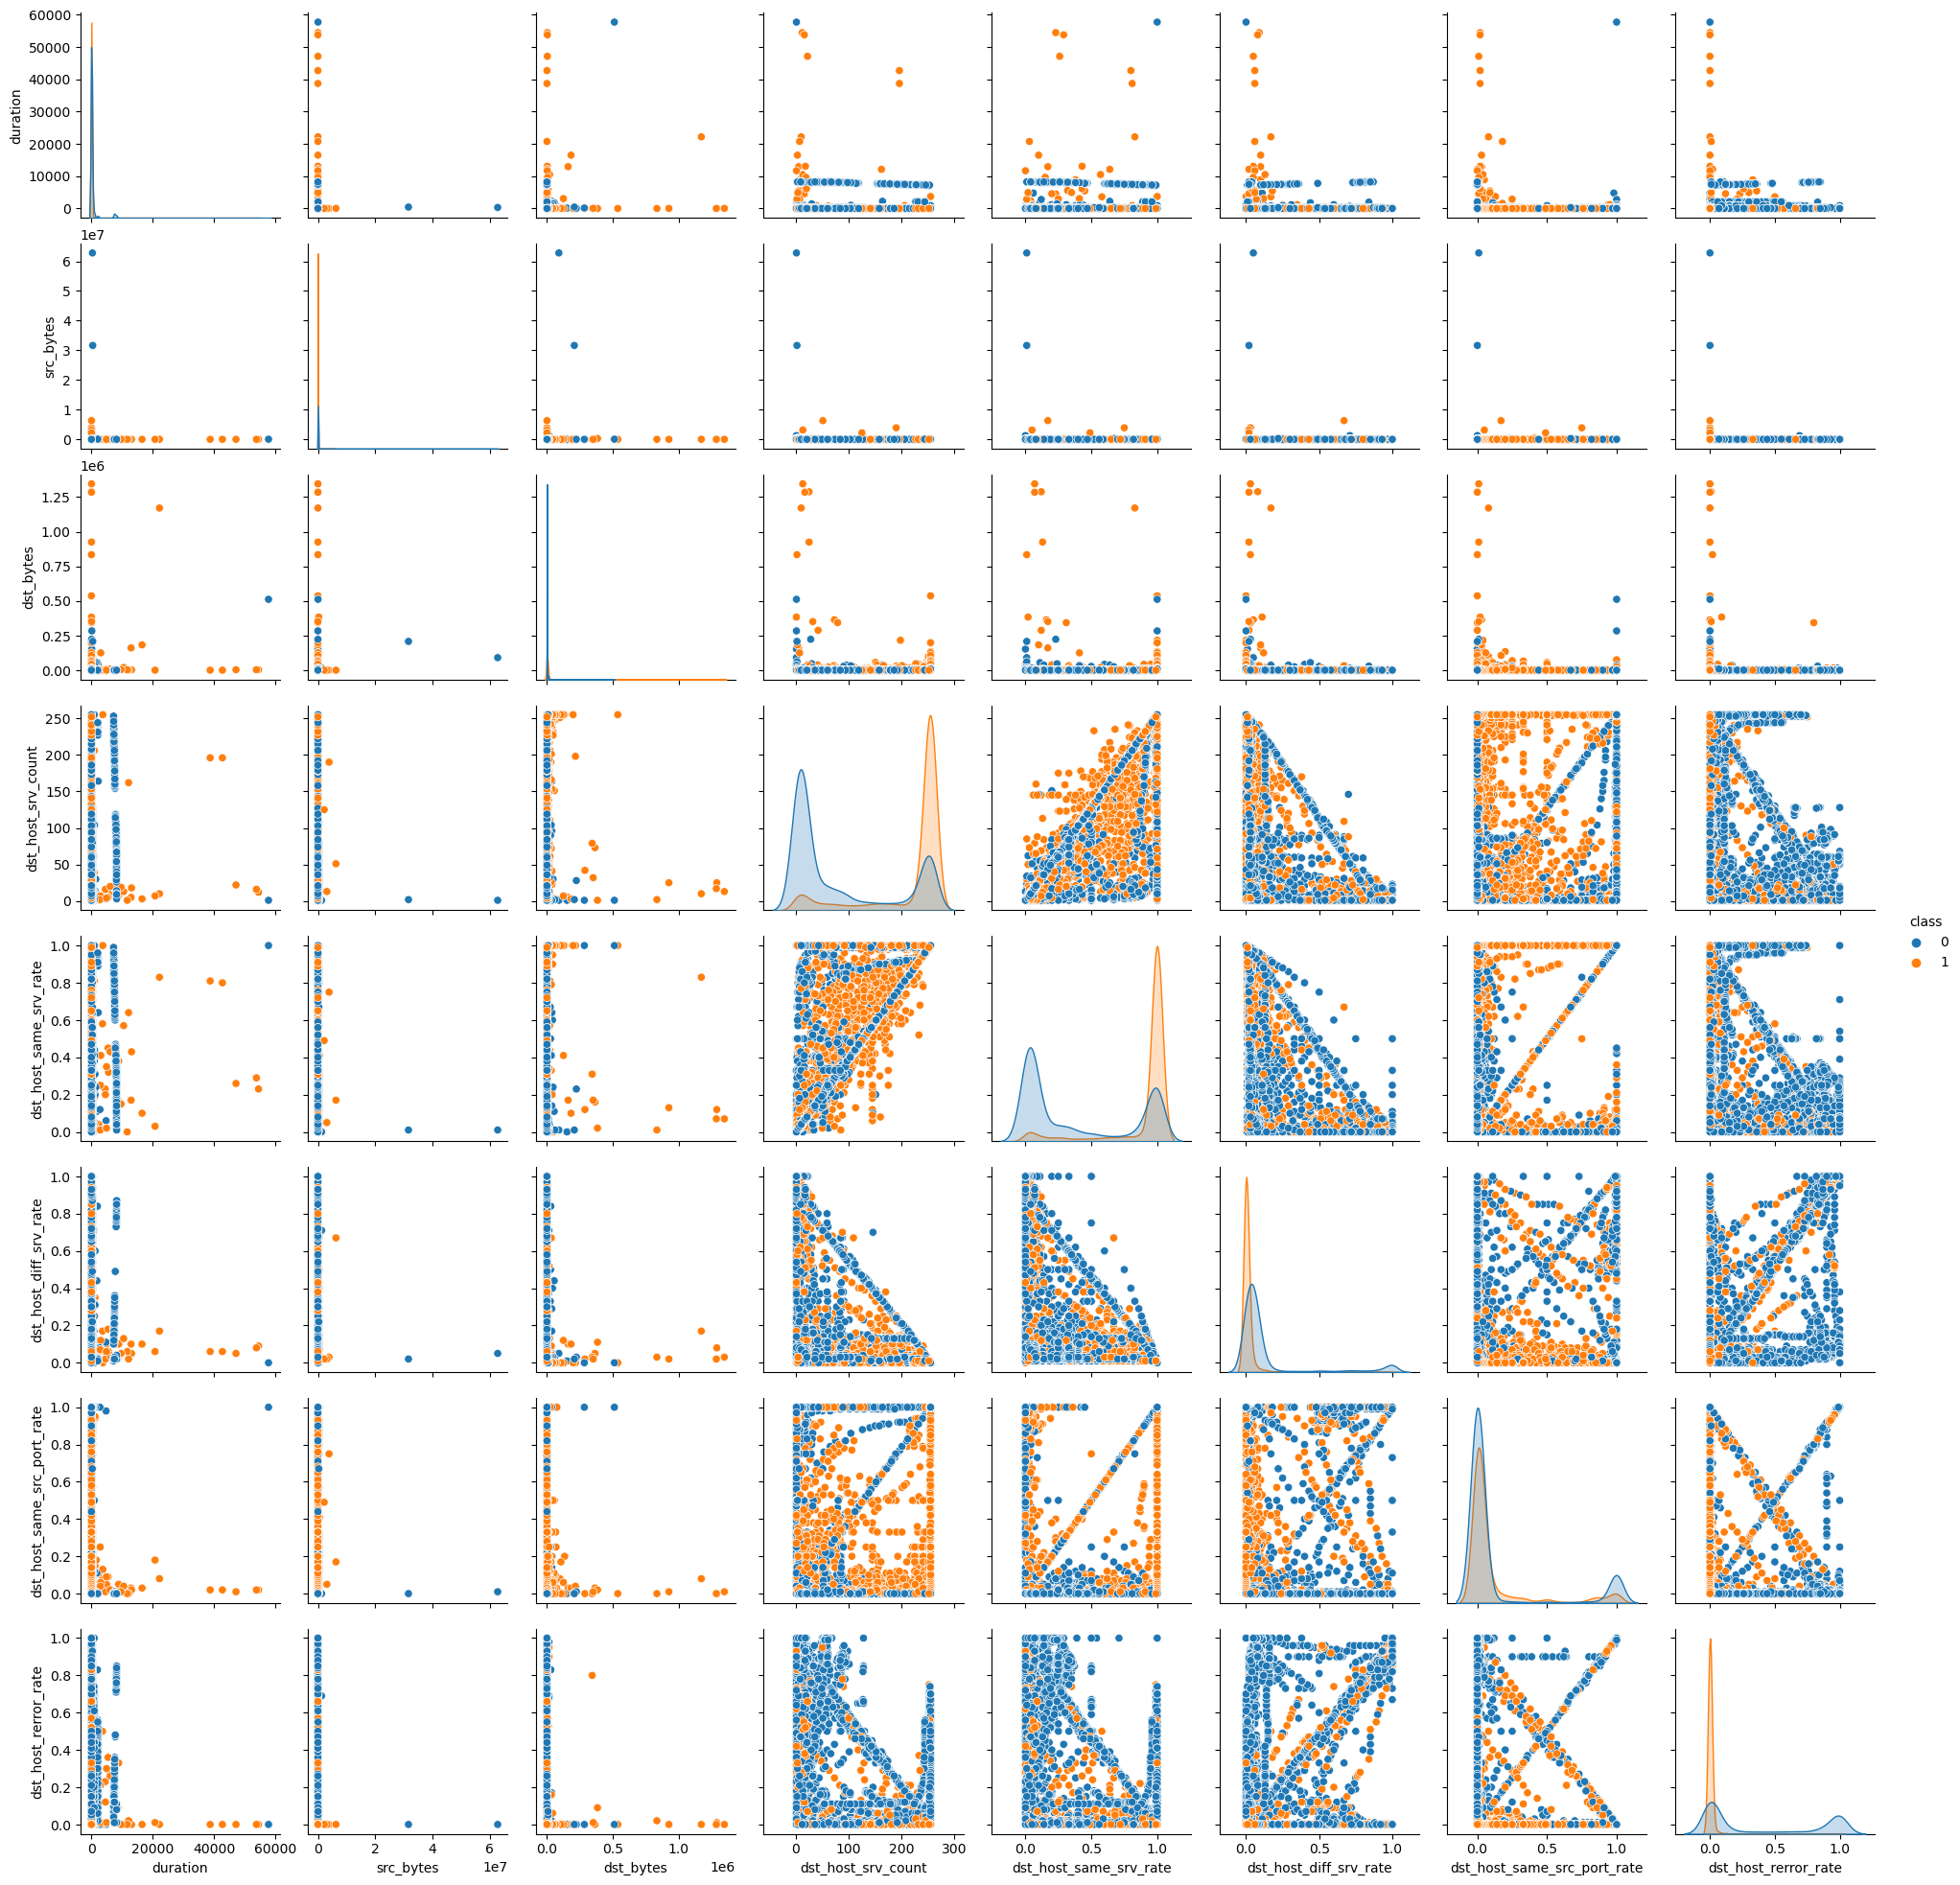

In [39]:
# Pairplot: Visualize pairwise relationships between numerical features
sns.pairplot(Data[numerical_features + ["class"]], hue="class")
plt.show()

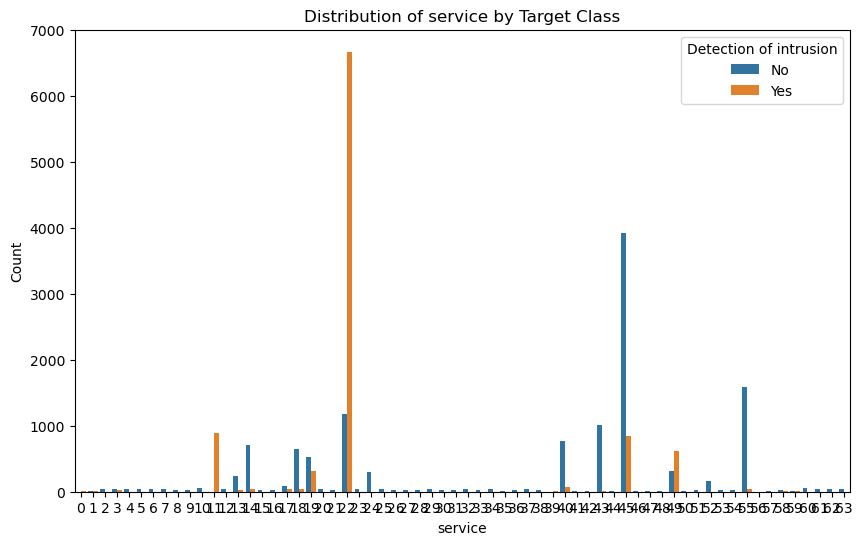

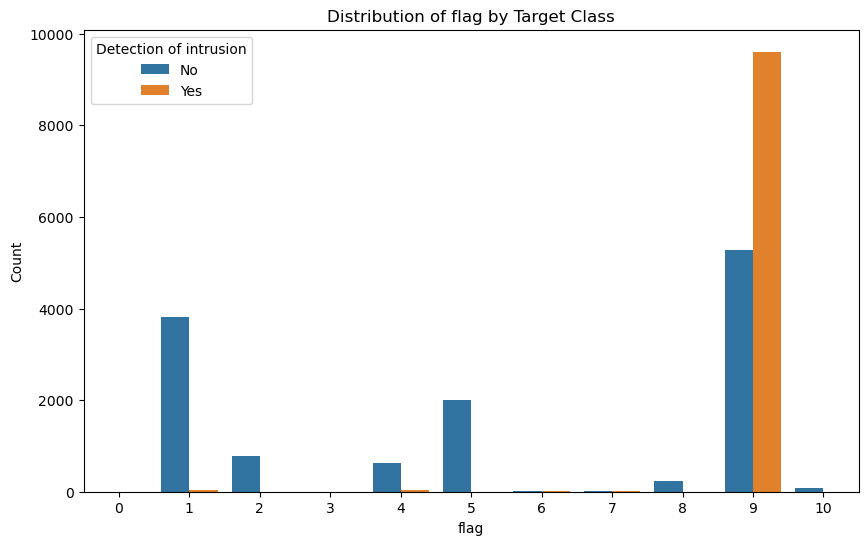

In [40]:
# Barplot: Compare the distribution of categorical features across different target classes
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=feature, hue="class", data=Data)
    plt.title(f"Distribution of {feature} by Target Class")
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.legend(title="Detection of intrusion", labels=["No", "Yes"])
    plt.show()

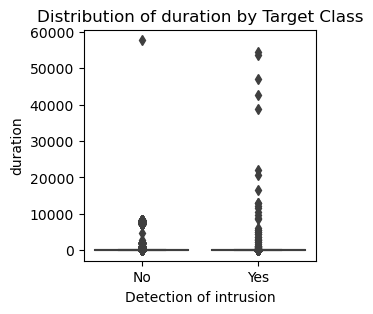

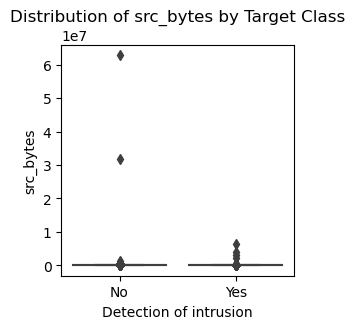

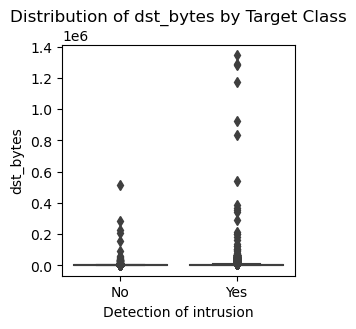

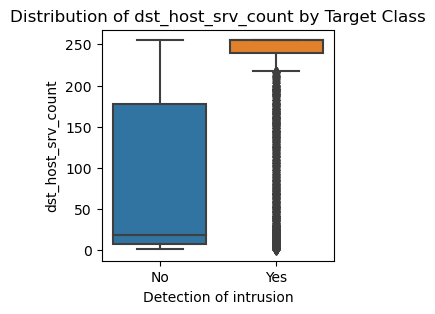

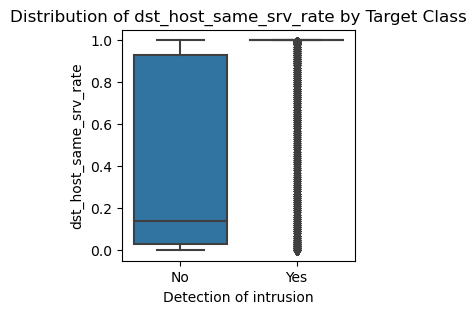

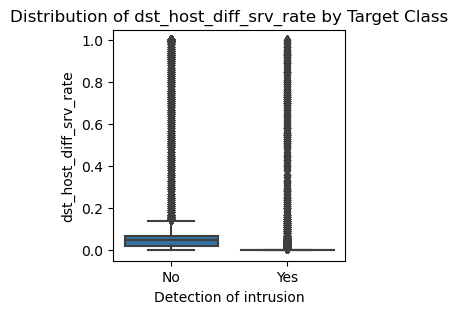

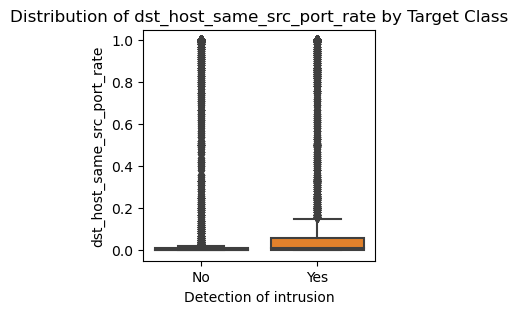

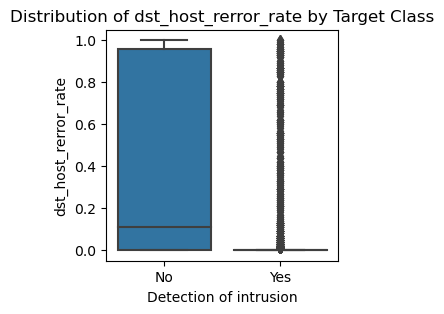

In [78]:
# Boxplot: Examine the distribution of numerical features across different target classes
for feature in numerical_features:
    plt.figure(figsize=(3, 3))
    sns.boxplot(x="class", y=feature, data=Data)
    plt.title(f"Distribution of {feature} by Target Class")
    plt.xlabel("Detection of intrusion")
    plt.ylabel(feature)
    plt.xticks([0, 1], ["No", "Yes"])
    plt.show()

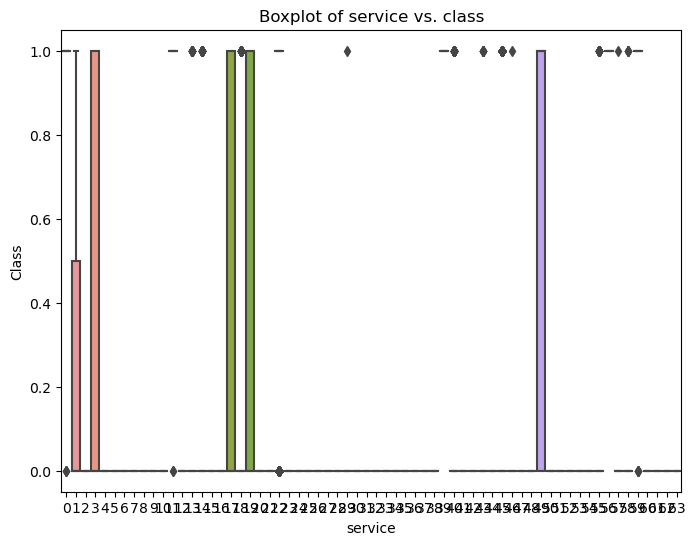

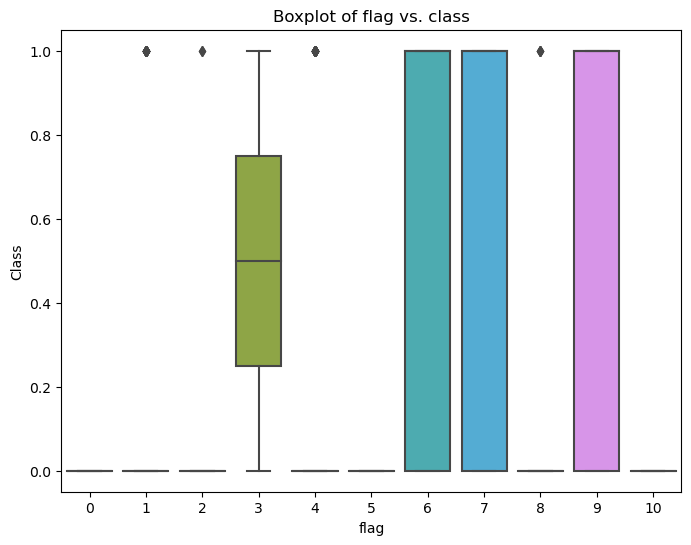

In [42]:
# Boxplot for categorical features
for feature in categorical_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=feature, y="class", data=Data)
    plt.title(f"Boxplot of {feature} vs. class")
    plt.xlabel(feature)
    plt.ylabel("Class")
    plt.show()

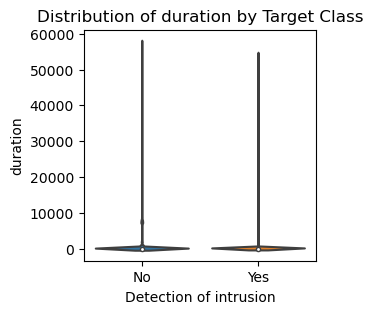

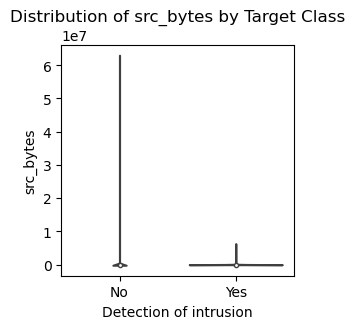

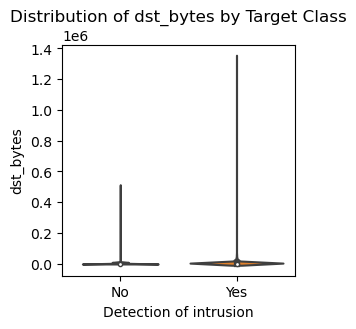

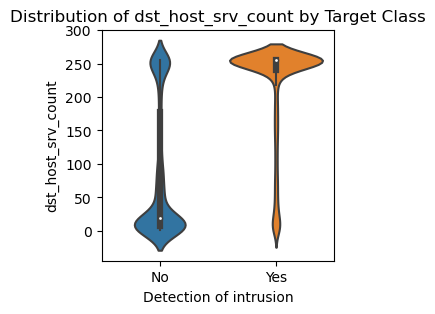

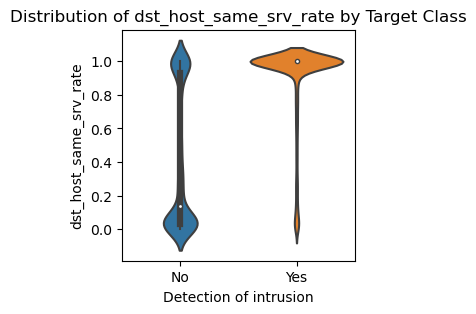

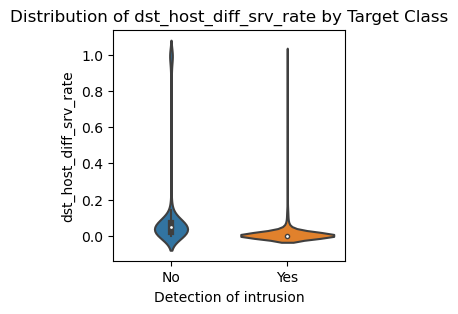

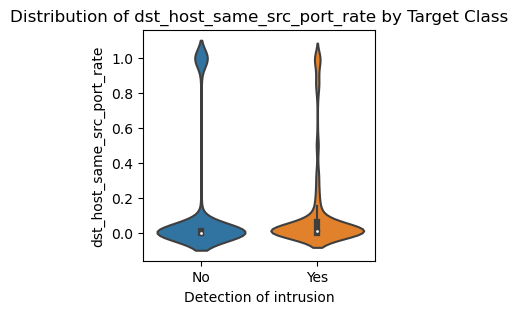

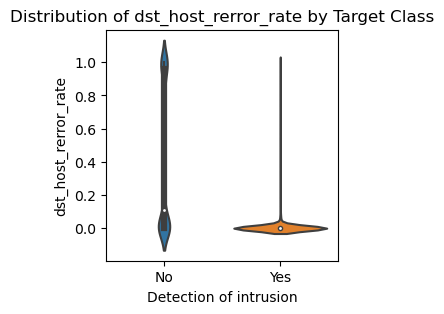

In [79]:
# Violinplot: Similar to boxplot, but provides a more informative representation of the distribution
for feature in numerical_features:
    plt.figure(figsize=(3, 3))
    sns.violinplot(x="class", y=feature, data=Data)
    plt.title(f"Distribution of {feature} by Target Class")
    plt.xlabel("Detection of intrusion")
    plt.ylabel(feature)
    plt.xticks([0, 1], ["No", "Yes"])
    plt.show()

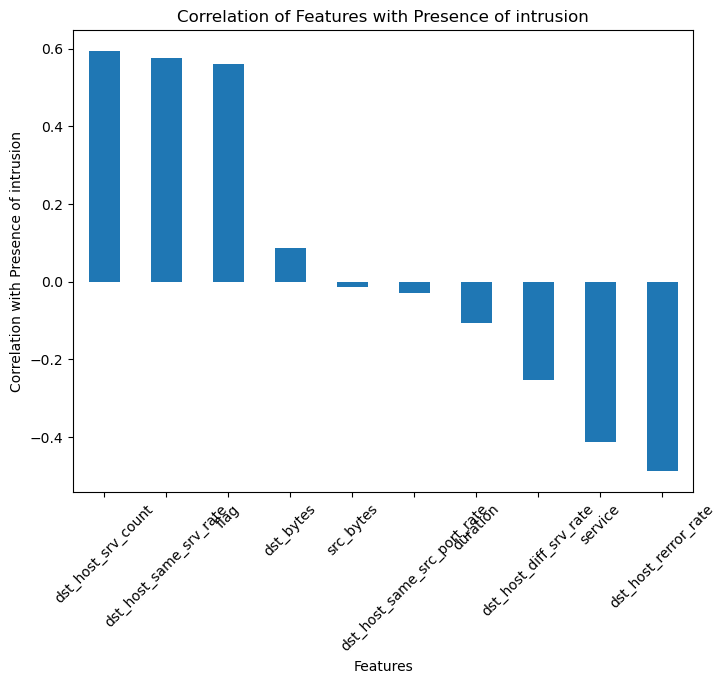

In [80]:
# Correlation with the target: Calculate and visualize the correlation between each feature and the target variable
target_correlation = Data.corr()["class"].sort_values(ascending=False)
plt.figure(figsize=(8, 6))
target_correlation.drop("class").plot(kind="bar")
plt.title("Correlation of Features with Presence of intrusion")
plt.xlabel("Features")
plt.ylabel("Correlation with Presence of intrusion")
plt.xticks(rotation=45)
plt.show()

## 3 - Construction et entrainement des modeles

In [45]:
import time

### LogisticRegression

In [46]:
from sklearn.linear_model import LogisticRegression

clfl = LogisticRegression(max_iter = 1200000)
start_time = time.time()
clfl.fit(x_train, y_train.values.ravel())
end_time = time.time()
print("Training time: ", end_time-start_time)


Training time:  0.15208983421325684


In [47]:
start_time = time.time()
y_test_pred = clfl.predict(x_train)
end_time = time.time()
print("Testing time: ", end_time-start_time)

Testing time:  0.008998394012451172


In [48]:
lg_model = LogisticRegression(random_state = 42)
lg_model.fit(x_train, y_train)

LogisticRegression(random_state=42)

In [49]:
lg_train, lg_test = lg_model.score(x_train , y_train), lg_model.score(x_test , y_test)

print(f"Training Score: {lg_train}")
print(f"Test Score: {lg_test}")

Training Score: 0.8130627774254915
Test Score: 0.8094392661636337


In [50]:
pip install optuna

In [51]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

### KNeighborsClassifier

In [52]:
def objective(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [53]:
study_KNN = optuna.create_study(direction='maximize')
study_KNN.optimize(objective, n_trials=1)
print(study_KNN.best_trial)

FrozenTrial(number=0, state=1, values=[0.9621245746412191], datetime_start=datetime.datetime(2024, 3, 17, 18, 29, 50, 983569), datetime_complete=datetime.datetime(2024, 3, 17, 18, 29, 54, 11260), params={'KNN_n_neighbors': 12}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'KNN_n_neighbors': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=0, value=None)


In [54]:
KNN_model = KNeighborsClassifier(n_neighbors=study_KNN.best_trial.params['KNN_n_neighbors'])
KNN_model.fit(x_train, y_train)

KNN_train, KNN_test = KNN_model.score(x_train, y_train), KNN_model.score(x_test, y_test)

print(f"Train Score: {KNN_train}")
print(f"Test Score: {KNN_test}")

Train Score: 0.9681039949270768
Test Score: 0.9621245746412191


### DecisionTreeClassifier

In [55]:
from sklearn.tree import DecisionTreeClassifier

clfd = DecisionTreeClassifier(criterion ="entropy", max_depth = 4)
start_time = time.time()
clfd.fit(x_train, y_train.values.ravel())
end_time = time.time()
print("Training time: ", end_time-start_time)

Training time:  0.05299544334411621


In [56]:
start_time = time.time()
y_test_pred = clfd.predict(x_train)
end_time = time.time()
print("Testing time: ", end_time-start_time)

Testing time:  0.0059964656829833984


In [57]:
def objective(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 10, log=False)
    classifier_obj = DecisionTreeClassifier(max_features = dt_max_features, max_depth = dt_max_depth)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [58]:
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective, n_trials=30)
print(study_dt.best_trial)

FrozenTrial(number=14, state=1, values=[0.9831335996449179], datetime_start=datetime.datetime(2024, 3, 17, 18, 29, 58, 853810), datetime_complete=datetime.datetime(2024, 3, 17, 18, 29, 59, 177810), params={'dt_max_depth': 23, 'dt_max_features': 6}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=10, log=False, low=2, step=1)}, trial_id=14, value=None)


In [59]:
dt = DecisionTreeClassifier(max_features = study_dt.best_trial.params['dt_max_features'], max_depth = study_dt.best_trial.params['dt_max_depth'])
dt.fit(x_train, y_train)

dt_train, dt_test = dt.score(x_train, y_train), dt.score(x_test, y_test)

print(f"Train Score: {dt_train}")
print(f"Test Score: {dt_test}")

Train Score: 0.9972733037412809
Test Score: 0.9815061399615328


### Random Forest Classifier (RFC)

In [81]:
# Utilisation de Optuna pour optimiser les hyperparamètres
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 1000, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    classifier_obj = RandomForestClassifier(n_estimators=n_estimators, 
                                             max_depth=max_depth,
                                             min_samples_split=min_samples_split,
                                             min_samples_leaf=min_samples_leaf)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

study_rfc = optuna.create_study(direction='maximize')
study_rfc.optimize(objective, n_trials=30)
print(study_rfc.best_trial)

FrozenTrial(number=26, state=1, values=[0.9862405681313804], datetime_start=datetime.datetime(2024, 3, 17, 21, 18, 50, 760082), datetime_complete=datetime.datetime(2024, 3, 17, 21, 19, 0, 954081), params={'n_estimators': 202, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 1}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=True, low=50, step=1), 'max_depth': IntDistribution(high=20, log=False, low=3, step=1), 'min_samples_split': IntDistribution(high=20, log=False, low=2, step=1), 'min_samples_leaf': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=26, value=None)


In [82]:
# Entraînement du meilleur modèle RFC
rfc = RandomForestClassifier(n_estimators=study_rfc.best_trial.params['n_estimators'],
                              max_depth=study_rfc.best_trial.params['max_depth'],
                              min_samples_split=study_rfc.best_trial.params['min_samples_split'],
                              min_samples_leaf=study_rfc.best_trial.params['min_samples_leaf'])
rfc.fit(x_train, y_train)
rfc_train, rfc_test = rfc.score(x_train, y_train), rfc.score(x_test, y_test)
print(f"Train Score (RFC): {rfc_train}")
y_test_pred_RFC = rfc.predict(x_test)
print(f"Test Score (RFC): {rfc_test}")

Train Score (RFC): 0.9943563728598604
Test Score (RFC): 0.9859446663707649


### Support Vector Machine (SVM)

In [83]:
# Création du modèle SVM
svc = SVC()
svc.fit(x_train, y_train)

SVC()

In [84]:
# Évaluation du modèle
svc_train, svc_test = svc.score(x_train, y_train), svc.score(x_test, y_test)
print(f"Train Score (SVM): {svc_train}")
y_test_pred_SVC = svc.predict(x_test)
print(f"Test Score (SVM): {svc_test}")

Train Score (SVM): 0.9315155358275206
Test Score (SVM): 0.9307589880159787


### Gaussian Naive Bayes

In [85]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
start_time = time.time()
GNB.fit(x_train, y_train.values.ravel())
end_time = time.time()
print("Training time: ",end_time-start_time)

Training time:  0.30932092666625977


In [86]:
start_time = time.time()
y_test_pred_GNB = GNB.predict(x_test)
end_time = time.time()

In [87]:
print("Testing time: ",end_time-start_time)

Testing time:  0.07499980926513672


In [88]:
gnb_train,gnb_test=GNB.score(x_train, y_train),GNB.score(x_test,y_test);
print(f"Train score is: {gnb_train}" )
print(f"Test score is:{gnb_train}")

Train score is: 0.8166138237159163
Test score is:0.8166138237159163


In [89]:
data = [["KNN", KNN_train, KNN_test],
        ["Logistic Regression", lg_train, lg_test],
        ["Decision Tree", dt_train, dt_test],
        ["Random Forest Classifier", rfc_train, dt_test],
        ["Support Vector Machine", svc_train, svc_test],
        ["Gaussian Naive Bayes ", gnb_train, gnb_test]
       ]

col_names = ["Model", "Train Score", "Test Score"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒══════════════════════════╤═══════════════╤══════════════╕
│ Model                    │   Train Score │   Test Score │
╞══════════════════════════╪═══════════════╪══════════════╡
│ KNN                      │      0.968104 │     0.962125 │
├──────────────────────────┼───────────────┼──────────────┤
│ Logistic Regression      │      0.813063 │     0.809439 │
├──────────────────────────┼───────────────┼──────────────┤
│ Decision Tree            │      0.997273 │     0.981506 │
├──────────────────────────┼───────────────┼──────────────┤
│ Random Forest Classifier │      0.994356 │     0.981506 │
├──────────────────────────┼───────────────┼──────────────┤
│ Support Vector Machine   │      0.931516 │     0.930759 │
├──────────────────────────┼───────────────┼──────────────┤
│ Gaussian Naive Bayes     │      0.816614 │     0.817725 │
╘══════════════════════════╧═══════════════╧══════════════╛


In [90]:
pip install catboost

In [91]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [92]:
SEED = 42

# Decision Tree Model
dtc = DecisionTreeClassifier()

# KNN
knn = KNeighborsClassifier()

# LOGISTIC REGRESSION MODEL

lr = LogisticRegression()

# Initialiser les nouveaux modèles
rfc = RandomForestClassifier()
svc = SVC()
xgb = XGBClassifier()

In [93]:
from sklearn.model_selection import cross_val_score
models = {}
models['KNeighborsClassifier']= knn
models['LogisticRegression']= lr
models['DecisionTreeClassifier']= dtc
models['RandomForestClassifier'] = rfc
models['SupportVectorMachine'] = svc
models['XGBoostClassifier'] = xgb

In [94]:
scores = {}
for name in models:
  scores[name]={}
  for scorer in ['precision','recall']:
    scores[name][scorer] = cross_val_score(models[name], x_train, y_train, cv=10, scoring=scorer)

In [95]:
from sklearn.model_selection import cross_val_score

# Initialiser un dictionnaire pour stocker les scores
scores = {}

# Calculer les scores de précision et de rappel pour chaque modèle
for name, model in models.items():
    scores[name] = {}
    for scorer in ['precision', 'recall']:
        scores[name][scorer] = cross_val_score(model, x_train, y_train, cv=10, scoring=scorer)

# Afficher les scores pour chaque modèle
for name in models:
    print("*" * (25 - len(name) // 2), name, 'Model Validation', "*" * (25 - len(name) // 2))

    for scorer in ['precision', 'recall']:
        mean = round(np.mean(scores[name][scorer]) * 100, 2)
        stdev = round(np.std(scores[name][scorer]) * 100, 2)
        print(f"Mean {scorer}: {mean}%, +/- {stdev}%")

    print()




*************** KNeighborsClassifier Model Validation ***************
Mean precision: 97.06%, +/- 0.59%
Mean recall: 95.86%, +/- 0.7%

**************** LogisticRegression Model Validation ****************
Mean precision: 75.84%, +/- 1.14%
Mean recall: 83.1%, +/- 1.89%

************** DecisionTreeClassifier Model Validation **************
Mean precision: 97.74%, +/- 0.61%
Mean recall: 97.61%, +/- 0.72%

************** RandomForestClassifier Model Validation **************
Mean precision: 98.14%, +/- 0.59%
Mean recall: 98.39%, +/- 0.6%

*************** SupportVectorMachine Model Validation ***************
Mean precision: 94.73%, +/- 0.81%
Mean recall: 88.05%, +/- 1.07%

***************** XGBoostClassifier Model Validation *****************
Mean precision: 98.41%, +/- 0.48%
Mean recall: 98.53%, +/- 0.38%



<Axes: >

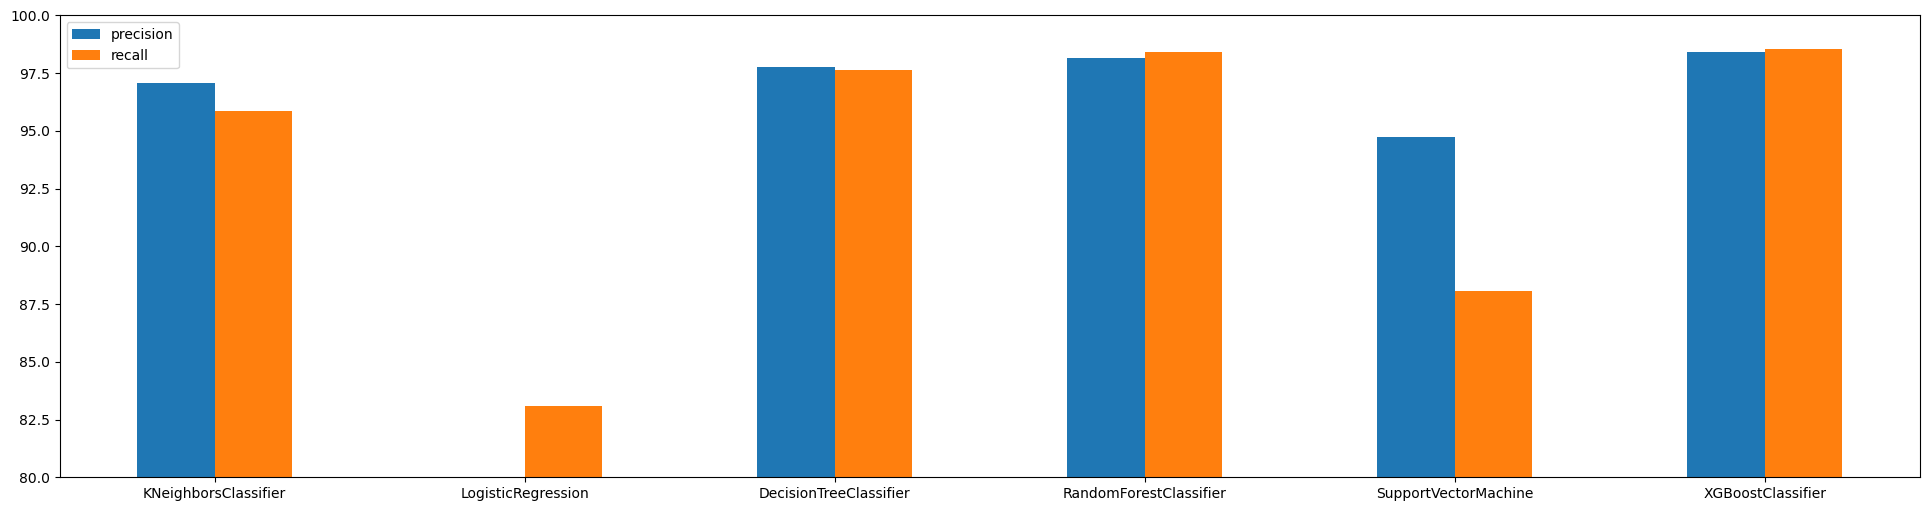

In [96]:
for name in models:
    for scorer in ['precision','recall']:
        scores[name][scorer] = scores[name][scorer].mean()
scores=pd.DataFrame(scores).swapaxes("index", "columns")*100
scores.plot(kind = "bar",  ylim=[80,100], figsize=(24,6), rot=0)

In [97]:
models = {}
models['KNeighborsClassifier']= knn
models['LogisticRegression']= lr
models['DecisionTreeClassifier']= dtc
models['RandomForestClassifier'] = rfc
models['SupportVectorMachine'] = svc
models['XGBoostClassifier'] = xgb


In [98]:
preds={}
for name in models:
    models[name].fit(x_train, y_train)
    preds[name] = models[name].predict(x_test)
print("Predictions complete.")

Predictions complete.


In [99]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score
def line(name,sym="*"):
    return sym*(25-len(name)//2)
target_names=["normal","anamoly"]
for name in models:
    print(line(name), name, 'Model Testing', line(name))
    print(confusion_matrix(y_test, preds[name]))
    print(line(name,'-'))
    print(classification_report(y_test, preds[name], target_names=target_names))

*************** KNeighborsClassifier Model Testing ***************
[[3726  116]
 [ 114 2803]]
---------------
              precision    recall  f1-score   support

      normal       0.97      0.97      0.97      3842
     anamoly       0.96      0.96      0.96      2917

    accuracy                           0.97      6759
   macro avg       0.97      0.97      0.97      6759
weighted avg       0.97      0.97      0.97      6759

**************** LogisticRegression Model Testing ****************
[[3033  809]
 [ 479 2438]]
----------------
              precision    recall  f1-score   support

      normal       0.86      0.79      0.82      3842
     anamoly       0.75      0.84      0.79      2917

    accuracy                           0.81      6759
   macro avg       0.81      0.81      0.81      6759
weighted avg       0.81      0.81      0.81      6759

************** DecisionTreeClassifier Model Testing **************
[[3776   66]
 [  70 2847]]
--------------
              pr

<Axes: >

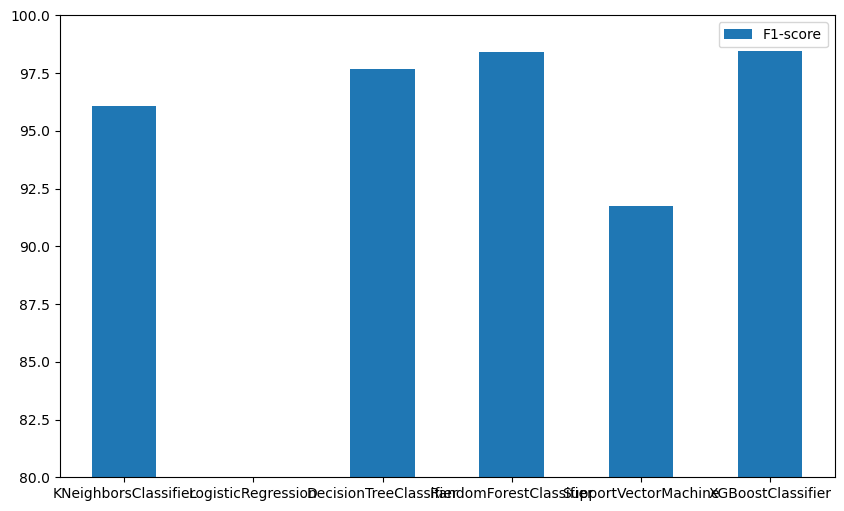

In [100]:
f1s = {}
for name in models:
    f1s[name]=f1_score(y_test, preds[name])
f1s=pd.DataFrame(f1s.values(),index=f1s.keys(),columns=["F1-score"])*100
f1s.plot(kind = "bar",  ylim=[80,100], figsize=(10,6), rot=0)

In [101]:
pip install dash

In [102]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import pandas as pd

In [103]:
# Assurez-vous d'avoir le DataFrame contenant les scores de vos modèles
data = {
    "Model": ["KNN", "Logistic Regression", "Decision Tree","Random Forest Classifier","Support Vector Machine","Gaussian Naive Bayes"],
    "Train Score": [0.97, 0.81, 0.99, 0.99, 0.93, 0.81],
    "Test Score": [0.96, 0.81, 0.98, 0.98, 0.93, 0.92]
}

df = pd.DataFrame(data)

In [105]:
# Initialiser l'application Dash
app = dash.Dash(__name__)

# Définir la mise en page de l'application
app.layout = html.Div([
    html.H1("Tableau de bord des scores de modèles"),
    dcc.Graph(id='model-scores', figure={
        'data': [
            {'x': df['Model'], 'y': df['Train Score'], 'type': 'bar', 'name': 'Train Score'},
            {'x': df['Model'], 'y': df['Test Score'], 'type': 'bar', 'name': 'Test Score'}
        ],
        'layout': {
            'title': 'Scores des modèles sur les ensembles d\'entraînement et de test'
        }
    })
])

# Exécuter l'application
if __name__ == '__main__':
    app.run_server(debug=True, port=8051)

In [ ]:
#Confusion matrix

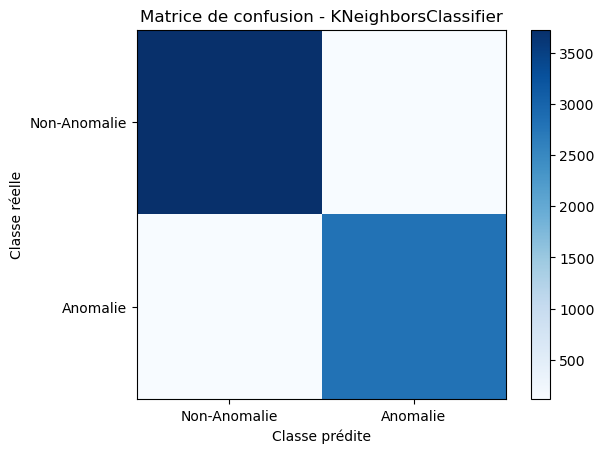

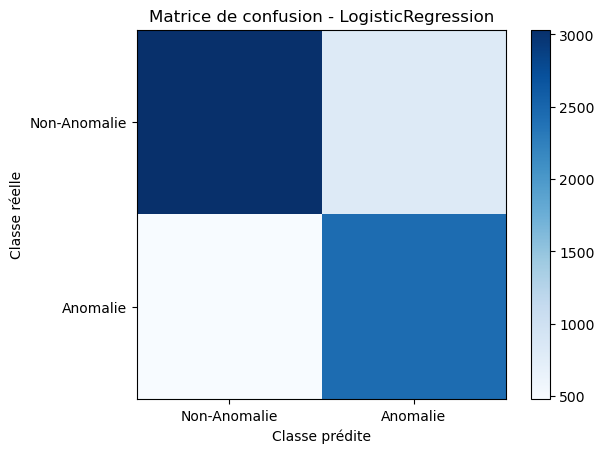

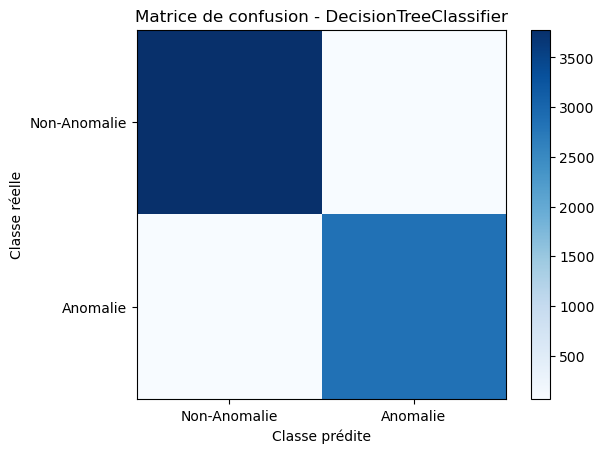

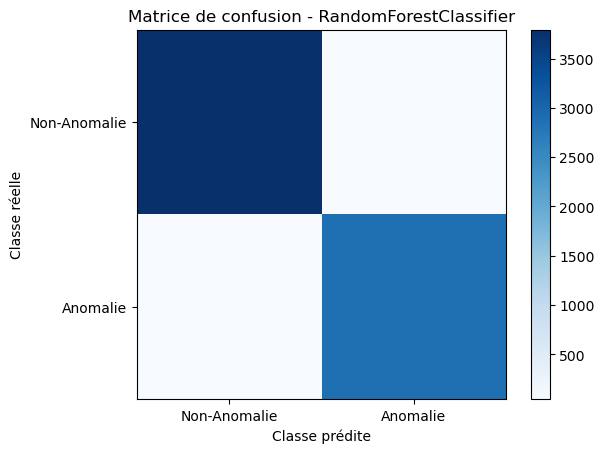

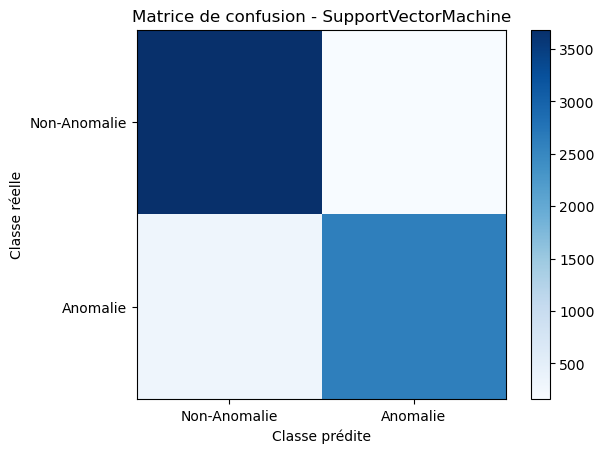

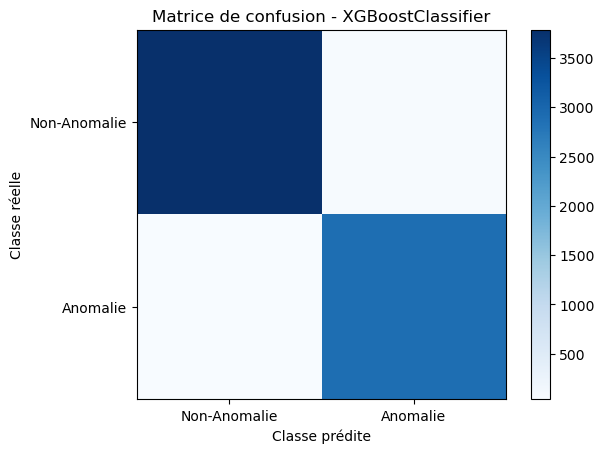

In [109]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Iterate over each model and plot its confusion matrix
for model_name, model in models.items():
    # Train the model
    model.fit(x_train, y_train)  # Assuming you have split your data into training and testing sets
    
    # Predict the labels
    y_pred = model.predict(x_test)
    
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    # Plot the confusion matrix
    plt.figure()
    plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
    plt.colorbar()
    plt.title(f'Matrice de confusion - {model_name}')
    plt.xlabel('Classe prédite')
    plt.ylabel('Classe réelle')
    plt.xticks(ticks=[0, 1], labels=['Non-Anomalie', 'Anomalie'])
    plt.yticks(ticks=[0, 1], labels=['Non-Anomalie', 'Anomalie'])
plt.show()

## 4 - Déploiment de modele

In [106]:
# Appliquer la regression logisitique sur notre base de donnée
Decisiontree=DecisionTreeClassifier()
Decisiontree.fit(x_train,y_train)

DecisionTreeClassifier()

In [107]:
# Enregistrer le modèle
pickle.dump(Decisiontree,open('model.pkl','wb'))